# Telco Customer Churn

In this notebook i'll be examining which variables are the strongest predictors of customer churn for a fictional Telco using machine learning techniques. The findings will be used to inform retention strategy ideas for the next quarter.

The data is available on [IBM's website](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113). It includes a main dataset and a number of supplementary datasets. I'll combine them all and inspect/clean it in the code below.

# Import Data + Packages

In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#settings
%matplotlib inline

# ml tools
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (StandardScaler,
                                  OneHotEncoder,
                                  power_transform,
                                  FunctionTransformer,
                                  LabelEncoder)
from featurewiz import featurewiz
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (StratifiedKFold,
                                    cross_val_predict,
                                    cross_val_score,
                                    train_test_split,
                                    GridSearchCV)

import scipy.stats as stats
import statsmodels
import statsmodels.stats.proportion as proportion
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from sklearn.feature_selection import SelectFromModel


import shap
from kmodes.kmodes import KModes

# model
import xgboost as xgb

# metrics
from sklearn.metrics import (confusion_matrix,
                            ConfusionMatrixDisplay,
                            RocCurveDisplay,
                            classification_report,
                            roc_curve,
                            roc_auc_score,
                            auc,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            r2_score,
                            mean_squared_error,
                            silhouette_score)



# style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

plt.style.use('seaborn')

# warnings
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

In [244]:
# load main dataset
churn_df = pd.read_excel("C:/Users/kates/Documents/Telco Customer Churn/CustomerChurn.xlsx")
churn_df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [245]:
# pull data from additional tables
demographics = pd.read_excel("C:/Users/kates/Documents/Telco Customer Churn/Telco_customer_churn_demographics.xlsx")
location = pd.read_excel("C:/Users/kates/Documents/Telco Customer Churn/Telco_customer_churn_location.xlsx")
services = pd.read_excel("C:/Users/kates/Documents/Telco Customer Churn/Telco_customer_churn_services.xlsx")

In [246]:
# merge datasets - discarding duplicate cols
datasets = [demographics, location, services]

for df in datasets:
    cols_initial_ds = churn_df.columns
    cols_to_keep = []
    cols_to_keep.append('Customer ID')
    cols = df.columns
    for col in cols:
        if col not in cols_initial_ds:
            cols_to_keep.append(col)
    churn_df = pd.merge(churn_df, df[cols_to_keep], on=['Customer ID','Customer ID'])
           
churn_df.columns

Index(['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn', 'Count',
       'Gender', 'Age', 'Under 30', 'Married', 'Number of Dependents',
       'Location ID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long',
       'Latitude', 'Longitude', 'Service ID', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer',
       'Avg Monthly Long Distance Charges', 'Internet Type',
       'Avg Monthly GB Download', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming Music', 'Unlimited Data',
       'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue'],
      dtype='objec

# Preprocessing

In [247]:
# check data types and nulls
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LoyaltyID                          7043 non-null   int64  
 1   Customer ID                        7043 non-null   object 
 2   Senior Citizen                     7043 non-null   object 
 3   Partner                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Tenure                             7043 non-null   int64  
 6   Phone Service                      7043 non-null   object 
 7   Multiple Lines                     7043 non-null   object 
 8   Internet Service                   7043 non-null   object 
 9   Online Security                    7043 non-null   object 
 10  Online Backup                      7043 non-null   object 
 11  Device Protection                  7043 non-null   objec

In [248]:
# replace vals in churn col
churn_df['Churn'].replace({'Yes':1,'No':0}, inplace =True)

# check proportion churn
print ('total customers in dataset = {}'.format(churn_df['Churn'].count()))
print ('customers churned = {}'.format(churn_df['Churn'].sum()))
print ('proportion customers churned = {}'.format(churn_df['Churn'].mean()))

total customers in dataset = 7043
customers churned = 1869
proportion customers churned = 0.2653698707936959


In [249]:
# convert cols that are supposed to be numeric
churn_df['Total Charges'] = pd.to_numeric(churn_df['Total Charges'], errors = 'coerce')

# new category zip code col
churn_df['Zip Code Cat'] = churn_df['Zip Code'].astype(str)

In [250]:
# check cat cols
churn_df.describe(exclude=["number", "bool_"])

,Customer ID,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Gender,Under 30,Married,Location ID,Country,State,City,Lat Long,Service ID,Quarter,Referred a Friend,Offer,Internet Type,Device Protection Plan,Premium Tech Support,Streaming Music,Unlimited Data,Zip Code Cat
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2,2,2,7043,1,1,1106,1679,7043,1,2,6,4,2,2,2,2,1625
top,7590-VHVEG,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Male,No,No,KQVCVY8549,United States,California,Los Angeles,"33.362575, -117.299644",FRZCGDEGJ1299,Q3,No,None,Fiber Optic,No,No,No,Yes,92028
freq,1,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,3555,5642,3641,1,7043,7043,293,43,1,7043,3821,3877,3035,4621,4999,4555,4745,43


In [251]:
#drop unnecessary cols
churn_df = churn_df.drop(['Location ID', 'Count', 'Country', 'State', 'Lat Long', 
             'LoyaltyID', 'Service ID', 'Customer ID', 'Quarter', 'Married'], axis=1)

In [252]:
# cities has high cardinality so lets see if we can reduce that by grouping some columns together
cities = list(churn_df['City'].value_counts().sort_values(ascending = False).head(10).index)
churn_df['City'].value_counts().sort_values(ascending = False).head(10)

Los Angeles      293
San Diego        285
San Jose         112
Sacramento       108
San Francisco    104
Fresno            61
Long Beach        60
Oakland           52
Escondido         51
Stockton          44
Name: City, dtype: int64

In [253]:
# save copy of dataset
churn_df_og = churn_df

# update city col
churn_df.loc[~churn_df['City'].isin(cities), 'City'] = 'Other'

In [254]:
# explore zipcode which also has high cardinality
churn_df['Zip Code Cat'].str[:3].value_counts().sort_values(ascending = False).head(10)

956    308
900    298
921    295
945    280
960    277
959    260
954    250
953    244
917    226
932    226
Name: Zip Code Cat, dtype: int64

In [255]:
# Group zipcodes starting with the same three characters and two characters together
churn_df['Zip Code Cat'] = churn_df['Zip Code Cat'].str[:3]
churn_df['Zip Code Cat 2'] = churn_df['Zip Code Cat'].str[:2]

# Explore Numerical Variables

In [256]:
#numeric cols
churn_df.describe()

,Tenure,Monthly Charges,Total Charges,Churn,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370,46.509726,0.468692,93486.071134,36.197455,-119.756684,1.951867,32.386767,22.958954,20.515405,64.761692,1.962182,6.860713,749.099262,3034.379056
std,24.559481,30.090047,2266.771362,0.441561,16.750352,0.962802,1856.768045,2.468929,2.154425,3.001199,24.542061,15.448113,20.418940,30.090047,7.902614,25.104978,846.660055,2865.204542
min,0.000000,18.250000,18.800000,0.000000,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,21.360000
25%,9.000000,35.500000,401.450000,0.000000,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,9.210000,3.000000,35.500000,0.000000,0.000000,70.545000,605.610000
50%,29.000000,70.350000,1397.475000,0.000000,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,22.890000,17.000000,70.350000,0.000000,0.000000,401.440000,2108.640000
75%,55.000000,89.850000,3794.737500,1.000000,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,36.395000,27.000000,89.850000,0.000000,0.000000,1191.100000,4801.145000
max,72.000000,118.750000,8684.800000,1.000000,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,49.790000,150.000000,3564.720000,11979.340000


In [257]:
# drop duplicate cols
churn_df = churn_df.drop(['Monthly Charge', 'Tenure', 'Number of Dependents', 'Number of Referrals'], axis = 1)

In [258]:
# create new dataset with cols to keep
new_churn_df = churn_df

# identify most significant relationships
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from math import sqrt

num_cols = list(new_churn_df.drop(['Churn'], axis = 1).select_dtypes(include=["number", "bool_"]).columns)

# Perform statistical test and calculate effect size for each continuous variable
significant_vars = {}
significant_vars_list = []

for column in new_churn_df[num_cols]:
    if column != 'Churn':
        target_group_1 = new_churn_df[new_churn_df['Churn'] == 1][column]
        target_group_0 = new_churn_df[new_churn_df['Churn'] == 0][column]
        
        # Perform the appropriate statistical test (t-test or Mann-Whitney U test)
        if len(set(new_churn_df[column])) > 2:
            statistic, p_value = mannwhitneyu(target_group_1, target_group_0, alternative='two-sided')
        else:
            statistic, p_value = ttest_ind(target_group_1, target_group_0, alternative='two-sided')
        
        if p_value < 0.05:  # Set desired significance level
            significant_vars_list.append(column)
            sig_var = {}
            sig_var['p_value'] = p_value
            
            # Calculate effect size (Cohen's d)
            mean_diff = target_group_1.mean() - target_group_0.mean()
            pooled_std = sqrt((target_group_1.var() + target_group_0.var()) / 2)
            effect_size = mean_diff / pooled_std
            sig_var['effect_size'] = effect_size
            sig_var['effect_size_abs'] = abs(effect_size)
            significant_vars[column] = sig_var

significant_vars_df = pd.DataFrame.from_dict(significant_vars, orient ='index')
significant_vars_df.sort_values('effect_size_abs', ascending = False)

,p_value,effect_size,effect_size_abs
Tenure in Months,3.386769e-210,-0.894442,0.894442
Total Long Distance Charges,1.160889e-90,-0.554529,0.554529
Total Revenue,1.652339e-108,-0.538926,0.538926
Monthly Charges,3.311628e-54,0.469507,0.469507
Age,3.193760e-20,0.259019,0.259019
Avg Monthly GB Download,1.568585e-20,0.114399,0.114399
Latitude,1.013550e-04,-0.093794,0.093794
Total Refunds,9.268112e-04,-0.079013,0.079013
Longitude,1.077368e-02,0.054516,0.054516
Total Extra Data Charges,1.791985e-04,0.016219,0.016219


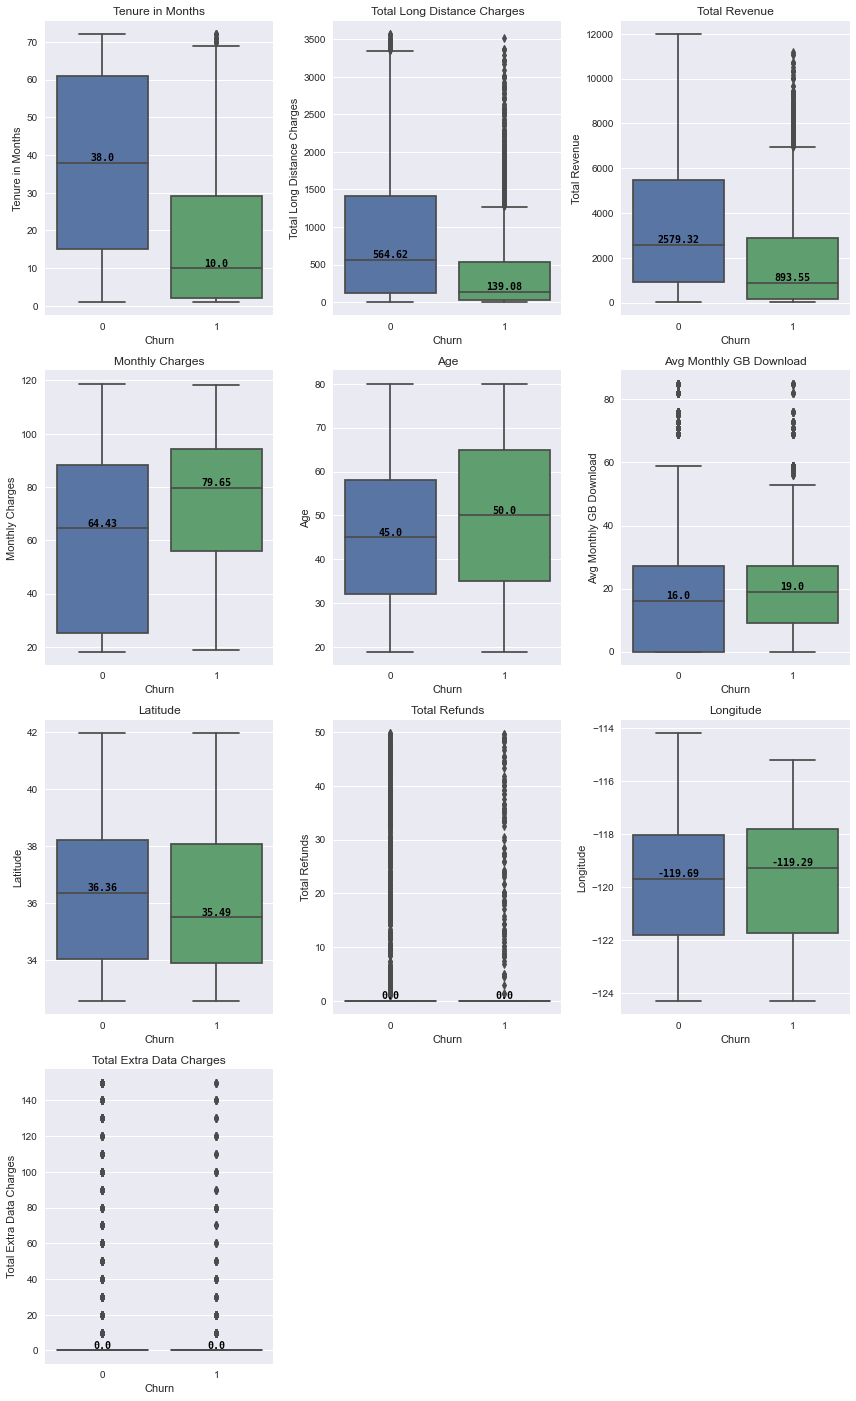

In [259]:
# viz most significant relationships
num_cols = list(significant_vars_df.sort_values('effect_size_abs', ascending = False).index.values)

a = 5
b = 3
c = 1

fig = plt.figure(figsize=(12,24))

for i in num_cols:
    plt.subplot(a,b,c)
    plt.title('{}'.format(i))
    box = sns.boxplot(data = churn_df, y = i, x = 'Churn')
    medians = new_churn_df.groupby('Churn')[i].median()
    for i in range(len(medians)):
        box.annotate(str(round(medians[i], 2)), xy = (i, medians[i]),
                    ha = 'center', va = 'bottom', color = 'black',
                    fontname = 'monospace', fontsize = 10, weight = 'bold')
    c = c + 1
    
plt.tight_layout()
plt.show()

# Numerical Variable Observations
- Monthly charges tend to be higher for customers that churn;
- Customers that churn are older on average;
- Customers that have been with the company for a short time are more likely to churn than customers that have been with the company a long time;
- Customers that churn use the service to download slightly more GB on average;
- The slight difference in latitudes and longitudes suggests location may also be a factor.

In [260]:
# drop more cols based on above
for col in new_churn_df.drop(['Churn'], axis = 1).select_dtypes(include=["number", "bool_"]).columns:
    if col not in significant_vars_list:
        new_churn_df.drop([col], axis = 1)
        
# also drop total refunds and total extra data charges due to low info
new_churn_df = new_churn_df.drop(['Total Extra Data Charges', 'Total Refunds'], axis = 1)

# Explore Categorical Variables

In [261]:
#cat cols
cat_cols = new_churn_df.select_dtypes(exclude=["number", "bool_"]).columns
cat_cols

Index(['Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Gender', 'Under 30', 'City', 'Referred a Friend', 'Offer',
       'Internet Type', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming Music', 'Unlimited Data', 'Zip Code Cat', 'Zip Code Cat 2'],
      dtype='object')

In [262]:
# Perform chi-square test for each categorical variable
significant_vars = {}
for column in cat_cols:
    if column != 'Churn':
        contingency_table = pd.crosstab(new_churn_df[column], new_churn_df['Churn'])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        if p_value < 0.05:  # Set your desired significance level
            sig_var = {}
            sig_var['P_Value'] = p_value
            n = contingency_table.sum().sum()
            phi_corr = np.sqrt(chi2 / n)
            sig_var['Cramers_V'] = association(contingency_table, method = 'cramer')
            significant_vars[column] = sig_var
            

        
significant_vars_df = pd.DataFrame.from_dict(significant_vars, orient ='index')
sig_cat_vars = list(significant_vars_df.sort_values('Cramers_V', ascending = False).index.values)

# drop cols based on above
for col in cat_cols:
    if col not in sig_cat_vars:
        new_churn_df.drop([col], axis = 1)
        
# view df
significant_vars_df.sort_values('Cramers_V', ascending = False)

,P_Value,Cramers_V
Contract,5.863038e-258,0.410116
Online Security,2.661150e-185,0.347400
Tech Support,1.443084e-180,0.342916
Internet Service,9.571788e-160,0.322455
Internet Type,2.150350e-141,0.304687
Payment Method,3.682355e-140,0.303359
Online Backup,2.079759e-131,0.292316
Device Protection,5.505219e-122,0.281580
Offer,7.020357e-102,0.261530
Streaming Movies,2.667757e-82,0.230951


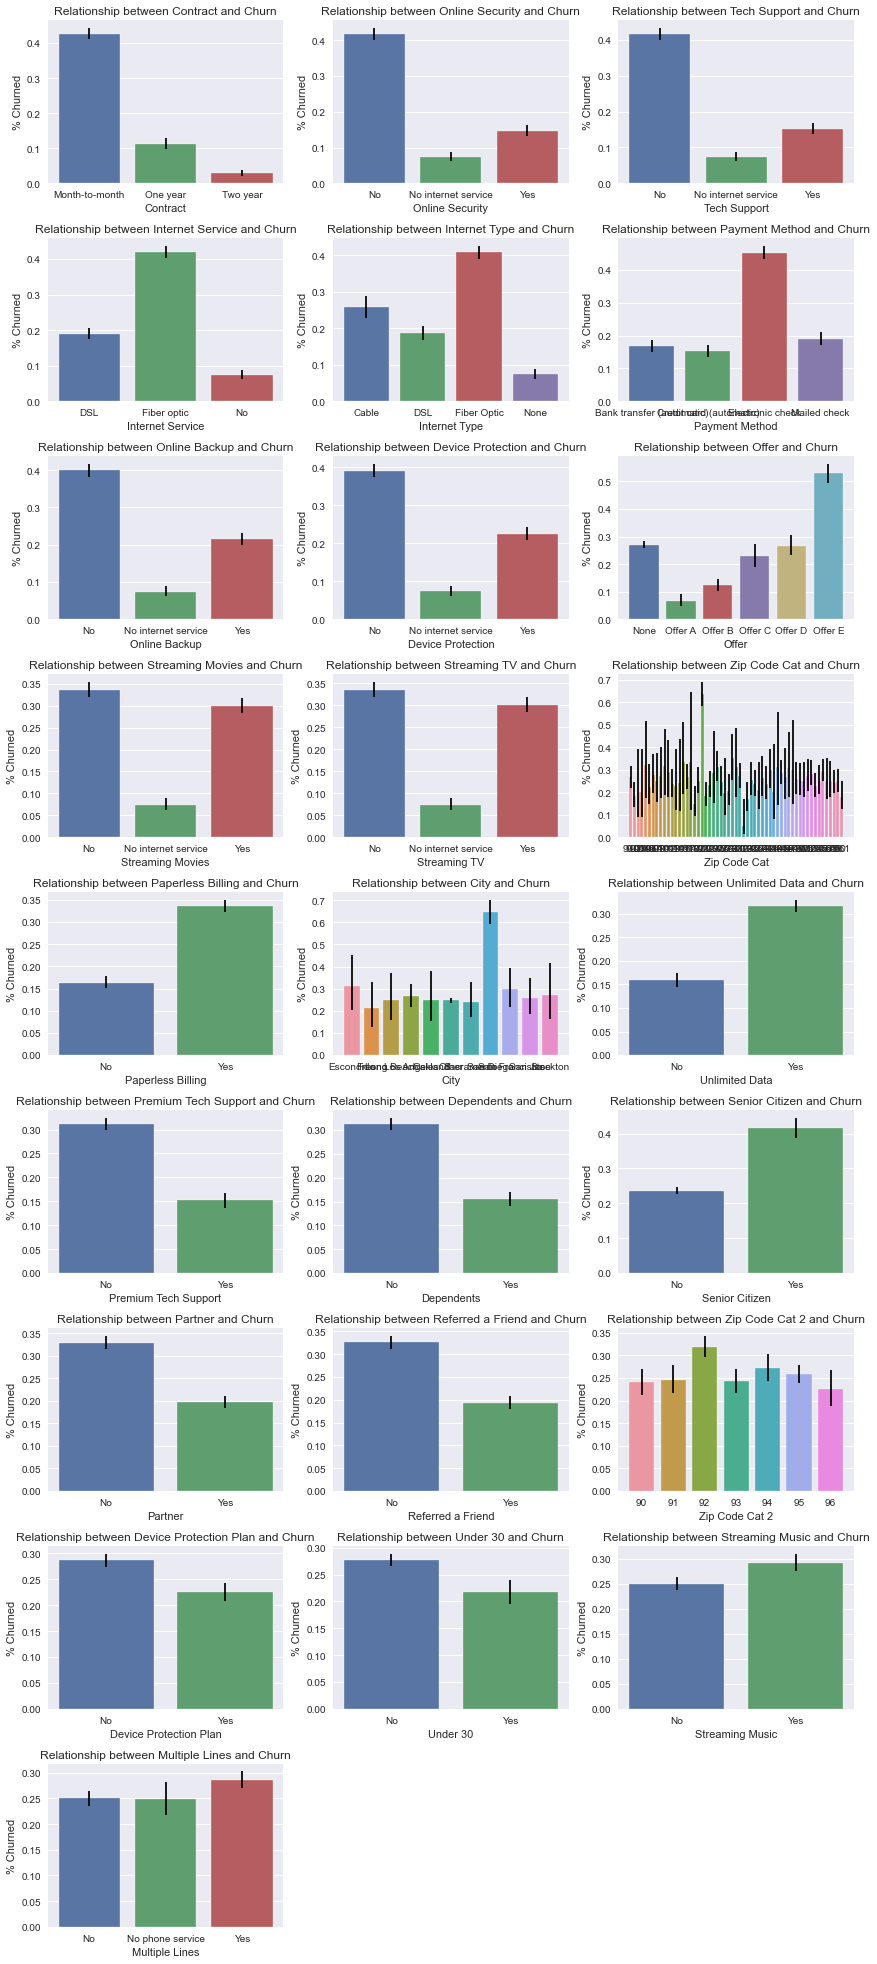

In [263]:
# visualise relationships for most sig vars

a = 10
b = 3
c = 1

fig = plt.figure(figsize=(12,30))

for column in sig_cat_vars:
        # Create a cross-tabulation table
    contingency_table = pd.crosstab(new_churn_df[column], new_churn_df['Churn'])
        
        # Calculate proportions and confidence intervals
    proportions = contingency_table.div(contingency_table.sum(1), axis=0)
    confidence_intervals = pd.DataFrame(index=proportions.index)

        
    for row in proportions.index:
        n = contingency_table.loc[row].sum()
        p = proportions.loc[row, 1]
        conf_interval = proportion.proportion_confint(p * n, n, method='wilson')
        confidence_intervals.loc[row, 'CI_lower'] = conf_interval[0]
        confidence_intervals.loc[row, 'CI_upper'] = conf_interval[1]
        
        # Plot the relationship with confidence intervals


    plt.subplot(a,b,c)
    #plt.figure()
    ax = sns.barplot(x=proportions.index, y=proportions[1])
    ax.errorbar(
            x=proportions.index, y=proportions[1],
            yerr=(proportions[1] - confidence_intervals['CI_lower'], confidence_intervals['CI_upper'] - proportions[1]),
            fmt='none', c='black'
            )
    plt.xlabel(column)
    plt.ylabel('% Churned')
    plt.title(f'Relationship between {column} and Churn')
    c = c + 1
    

    
    
plt.tight_layout()
plt.show()
        

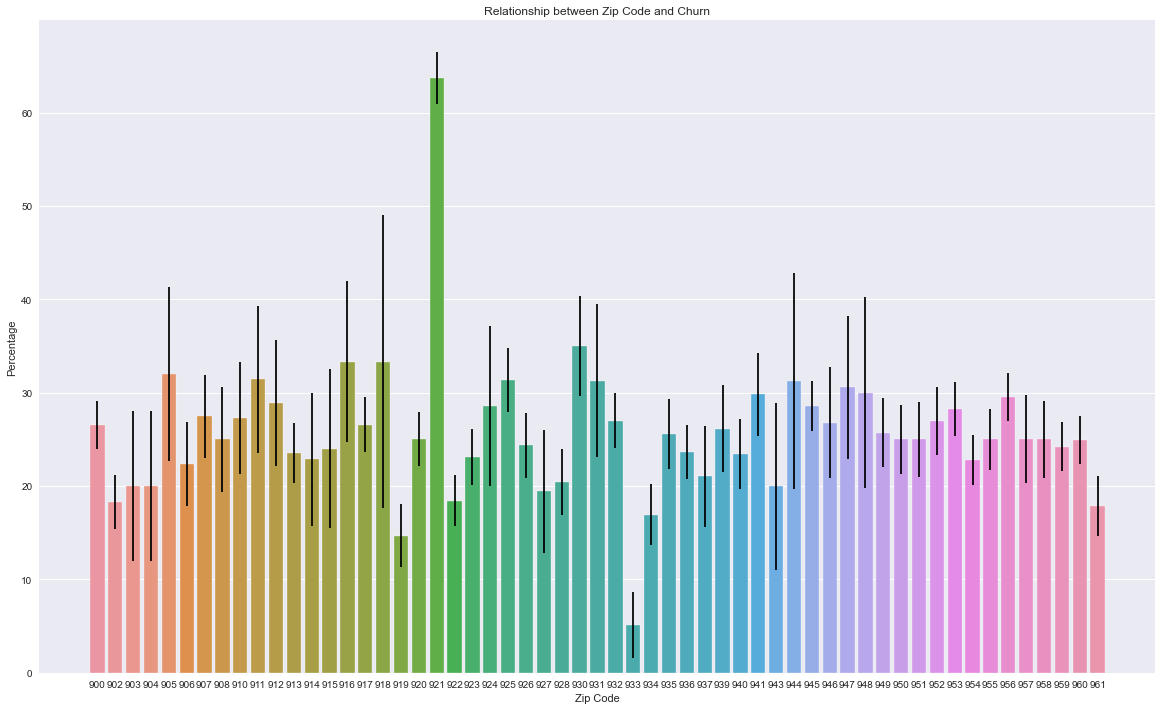

In [264]:
# Closer look at zip code
percentage_df = new_churn_df.groupby('Zip Code Cat')['Churn'].mean() * 100
conf_int_df = new_churn_df.groupby('Zip Code Cat')['Churn'].agg(lambda x: np.std(x) / np.sqrt(len(x))) * 100

# Plot the relationship with error bars showing percentages
plt.figure(figsize=(20,12))
sns.barplot(x=percentage_df.index, y=percentage_df.values, ci='sd')
plt.errorbar(x=percentage_df.index, y=percentage_df.values, yerr=conf_int_df.values, fmt='none', color='black', capsize=5)
plt.xlabel('Zip Code')
plt.ylabel('Percentage')
plt.title('Relationship between Zip Code and Churn')
plt.show()

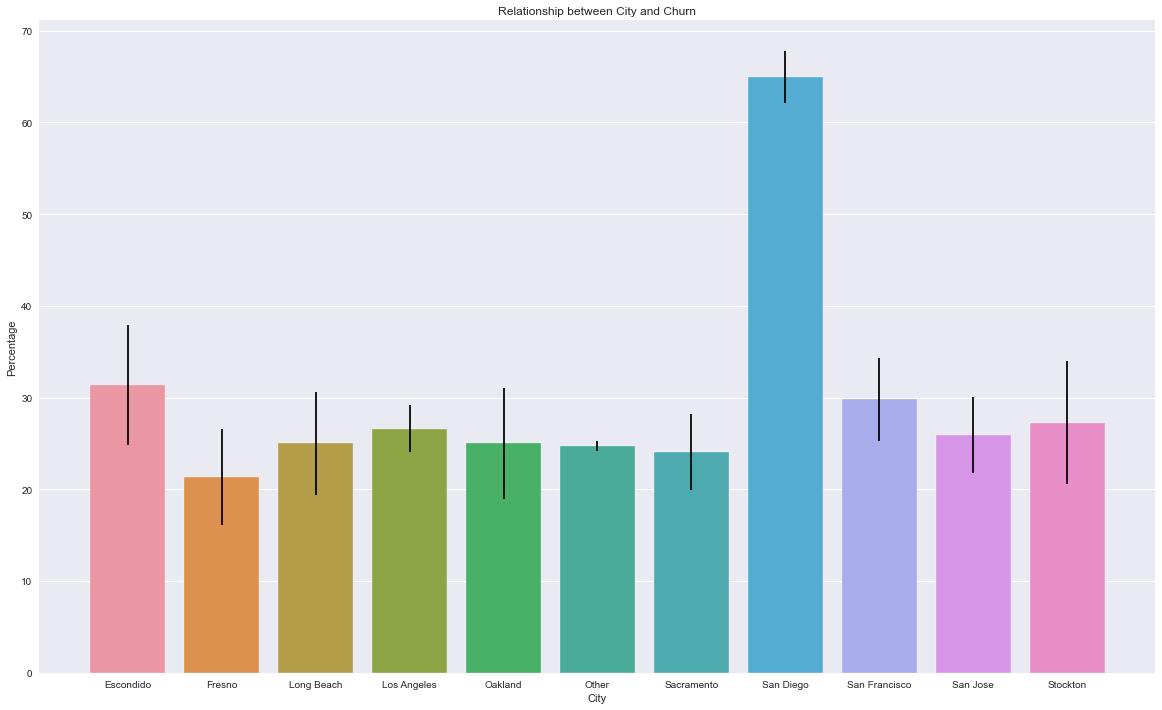

In [265]:
# Closer look at city
percentage_df = churn_df.groupby('City')['Churn'].mean() * 100
conf_int_df = churn_df.groupby('City')['Churn'].agg(lambda x: np.std(x) / np.sqrt(len(x))) * 100

# Plot the relationship with error bars showing percentages
plt.figure(figsize=(20,12))
sns.barplot(x=percentage_df.index, y=percentage_df.values, ci='sd')
plt.errorbar(x=percentage_df.index, y=percentage_df.values, yerr=conf_int_df.values, fmt='none', color='black', capsize=5)
plt.xlabel('City')
plt.ylabel('Percentage')
plt.title('Relationship between City and Churn')
plt.show()

In [266]:
# check city for zip codes starting with 921
new_churn_df[new_churn_df['Zip Code Cat'] == '921']['City'].value_counts().sort_values(ascending = False)

San Diego    285
Other         10
Name: City, dtype: int64

# Categorical Variable Observations

## Demographic Variables:

- When it comes to the demographic variables we see that customers that churn tend to be older on average and are less likely to have a family or a partner;
- We also that customers in San Diego are much more likely to churn than customers in other cities.

## Contract Variables:

- Customers that churn are more likely to be on a month to month contract, be paying with electronic check and have paperless billing; 
- Customers that stay with the Telco are more likely to have added extras in their contracts including online security, tech support, online backup and device protection;
- We see that customers with a contract including internet are more likely to churn. Of those customers, fiber optic customers are the most likely to churn. We also see that customers with unlimited data and streaming music are more likely to churn;
- Also of note is that customers that received Offer E are most likely to churn. Unsurprisingly customers that refer a friend are less likely to churn than customers that don't. 

# Train XGB Model to Predict Churn

In [267]:
# encode cat vars
from category_encoders import TargetEncoder
encoder = TargetEncoder()

for v in cat_cols:
    new_churn_df[v] = new_churn_df[v].astype(str)
    new_name = v + '_encoded'
    new_churn_df[new_name] = encoder.fit_transform(new_churn_df[v], new_churn_df['Churn'])
    new_churn_df = new_churn_df.drop([v], axis = 1)

In [268]:
# define function to identify optimum hyperparams
def objective(space):
    clf = xgb.XGBClassifier(
                        n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), 
                        gamma = space['gamma'], reg_alpha = int(space['reg_alpha']), 
                        min_child_weight = int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
           eval_set=evaluation, eval_metric='auc',
           early_stopping_rounds=10, verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [269]:

# define function to train model
def train_xgb_model(dataset, target):
    # Split the dataset into features and target
    
    X = dataset.drop(target, axis=1)
    y = pd.Series(dataset[target], index = X.index)
    
    pd.Series(new_churn_df.Churn.values, index = X.index)
    
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns, index = X.index)
    
    # Feature selection using XGBoost importance
    xgb_model = xgb.XGBClassifier(random_state=42)
    selector = SelectFromModel(xgb_model, threshold='median')
    selector.fit(X_scaled, y)
    selected_features = X_scaled.columns[selector.get_support()].tolist()
    X_selected = pd.DataFrame(selector.transform(X_scaled), columns = selected_features)
    
    # Split the selected features into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    
    def objective(space):
        clf = xgb.XGBClassifier(
                            n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), 
                            gamma = space['gamma'], reg_alpha = int(space['reg_alpha']), 
                            min_child_weight = int(space['min_child_weight']),
                            colsample_bytree=int(space['colsample_bytree']))

        evaluation = [(X_train, y_train), (X_test, y_test)]

        clf.fit(X_train, y_train,
               eval_set=evaluation, eval_metric='auc',
               early_stopping_rounds=10, verbose=False)

        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred>0.5)
        return {'loss': -accuracy, 'status': STATUS_OK}
    
    space = {'max_depth': hp.quniform('max_depth', 3, 18, 1),
             'gamma': hp.uniform('gamma', 1, 9),
             'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
             'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
             'reg_lambda': hp.uniform('reg_lambda', 0, 1),
             'n_estimators': 180,
             'seed':0
            }
    
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                           space = space,
                           algo = tpe.suggest,
                           max_evals = 100,
                           trials = trials)


    # train best model
    best_model = xgb.XGBClassifier(
        n_estimators = 300, max_depth = int(best_hyperparams['max_depth']),
        gamma = float(best_hyperparams['gamma']),
        reg_alpha = int(best_hyperparams['reg_alpha']),
        min_child_weight = int(best_hyperparams['min_child_weight']),
        colsample_bytree = float(best_hyperparams['colsample_bytree']),
        reg_lambda = float(best_hyperparams['reg_lambda']))

    best_model.fit(X_train, y_train)
    
    # Determine probabilities
    train_probabilities = best_model.predict_proba(X_train)[:, 1]
    test_probabilities = best_model.predict_proba(X_test)[:, 1]
    
    
    # Determine the optimum classification threshold
    fpr, tpr, thresholds = roc_curve(y_train, train_probabilities)
    optimal_threshold_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_idx]
    
    # Make predictions on the train and test sets with the optimum threshold
    train_predictions = best_model.predict_proba(X_train)[:, 1] > optimal_threshold
    test_predictions = best_model.predict_proba(X_test)[:, 1] > optimal_threshold
    
#     # Evaluate model performance on the train and test sets
#     print("Classification Report (Train Set):")
#     print(classification_report(y_train, best_model.predict(X_train)))
    
#     print("\n") 
    
    print("Confusion Matrix (Train Set):")
    print(confusion_matrix(y_train, train_predictions))
    
#     print("\n") 
    
#     print("Classification Report (Test Set):")
#     print(classification_report(y_test, best_model.predict(X_test)))
    
    print("\n") 
    
    print("Confusion Matrix (Test Set):")
    print(confusion_matrix(y_test, test_predictions))
    
    print("\n") 
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)
    
    # Calculate ROC curve and AUC on the train and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probabilities)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probabilities)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Plot ROC curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, label='ROC Curve (Train Set, AUC = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Train Set)')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr_test, tpr_test, label='ROC Curve (Test Set, AUC = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Test Set)')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Return the selected features, best model, and evaluation metrics
    return selected_features, best_model, precision, recall, f1, roc_auc_train, roc_auc_test, X_train, X_test, y_train, y_test, test_probabilities

100%|█████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83trial/s, best loss: -0.8097941802696949]
Confusion Matrix (Train Set):
[[3272  866]
 [ 337 1159]]


Confusion Matrix (Test Set):
[[813 223]
 [ 74 299]]




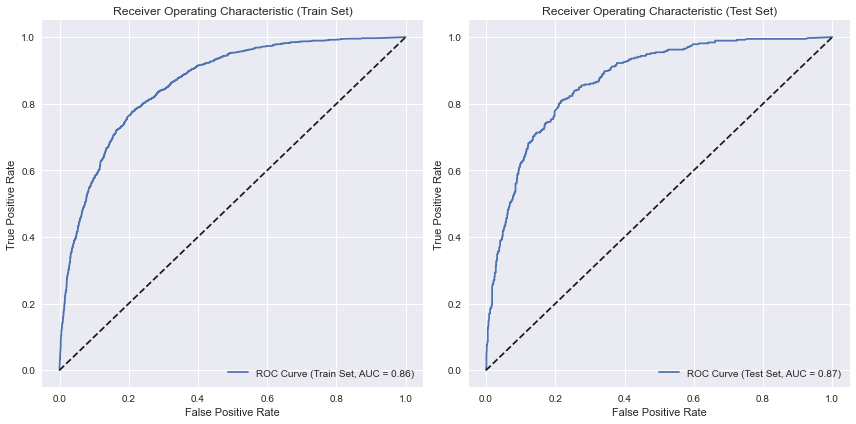

Selected Features:
['Monthly Charges', 'Total Charges', 'Tenure in Months', 'Total Long Distance Charges', 'Total Revenue', 'Dependents_encoded', 'Multiple Lines_encoded', 'Internet Service_encoded', 'Online Security_encoded', 'Online Backup_encoded', 'Tech Support_encoded', 'Streaming Movies_encoded', 'Contract_encoded', 'Paperless Billing_encoded', 'Payment Method_encoded', 'City_encoded', 'Internet Type_encoded', 'Streaming Music_encoded', 'Zip Code Cat_encoded']


Train ROC AUC Score: 0.8611963948328135
Test ROC AUC Score: 0.869768753817011
Recall Score: 0.8016085790884718
Precision Score: 0.5727969348659003
F1 Score: 0.6681564245810055


In [270]:
# train model
selected_features, best_model, precision, recall, f1, roc_auc_train, roc_auc_test, X_train, X_test, y_train, y_test, test_probabilities = train_xgb_model(new_churn_df, 'Churn')

# Print the selected features
print("Selected Features:")
print(selected_features)
print("\n") 

# Print the ROC AUC score
print(f"Train ROC AUC Score: {roc_auc_train}")

# Print the ROC AUC score
print(f"Test ROC AUC Score: {roc_auc_test}")

# Print the ROC AUC score
print(f"Recall Score: {recall}")

# Print the ROC AUC score
print(f"Precision Score: {precision}")

# Print the ROC AUC score
print(f"F1 Score: {f1}")

We see that this model is fairly accurate and has quite a high AUC of 0.87 on the test set. Theres quite a few more false positives than false negatives but this is probably not a bad thing as we would want the model to be sensitive when it comes to losing customers. 

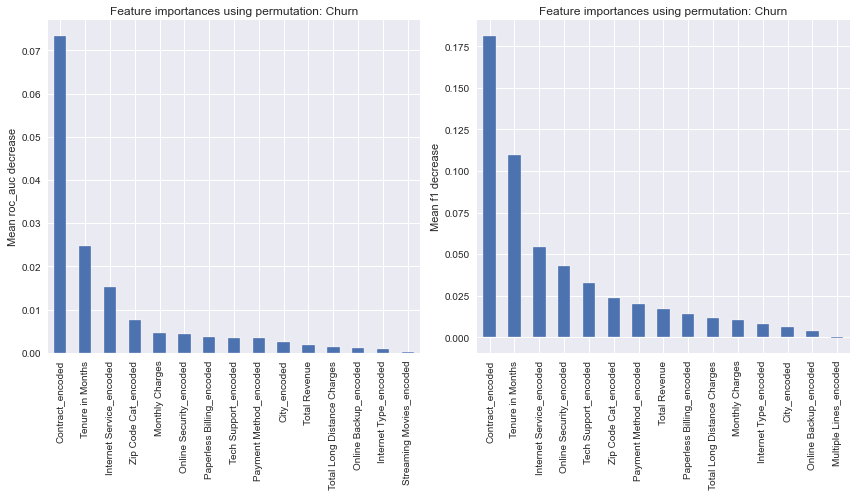

In [277]:
# check feature importances using permutation
scoring = ['roc_auc', 'f1']
r_multi = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring=scoring)

forest_importances_auc = pd.Series(r_multi['roc_auc'].importances_mean, index = selected_features)
forest_importances_f1 = pd.Series(r_multi['f1'].importances_mean, index = selected_features)

most_important_auc = forest_importances_auc.sort_values(ascending = False).head(15)
most_important_f1 = forest_importances_f1.sort_values(ascending = False).head(15)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

most_important_auc.sort_values(ascending = False).plot.bar(ax=ax1)
ax1.set_title('Feature importances using permutation: Churn')
ax1.set_ylabel('Mean roc_auc decrease')

most_important_f1.sort_values(ascending = False).plot.bar(ax=ax2)
ax2.set_title('Feature importances using permutation: Churn')
ax2.set_ylabel('Mean f1 decrease')

fig.tight_layout()
plt.show()

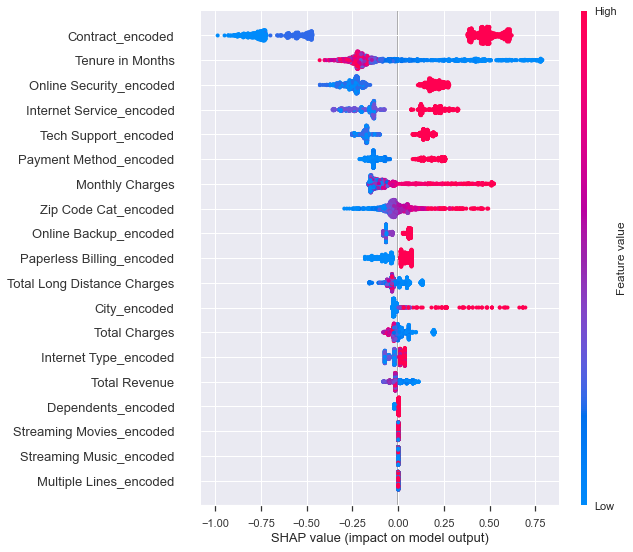

In [239]:
# check feature importance using shap
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)
shap_interaction = explainer.shap_interaction_values(X_test)
shap.plots.beeswarm(shap_values, max_display = 20)

The most important variables for predicting churn are contract, tenure, online security, internet service, tech support, payment method, monthly charges, zip code, online backup and paperless billing. 

Lets take a look at the interaction effects:

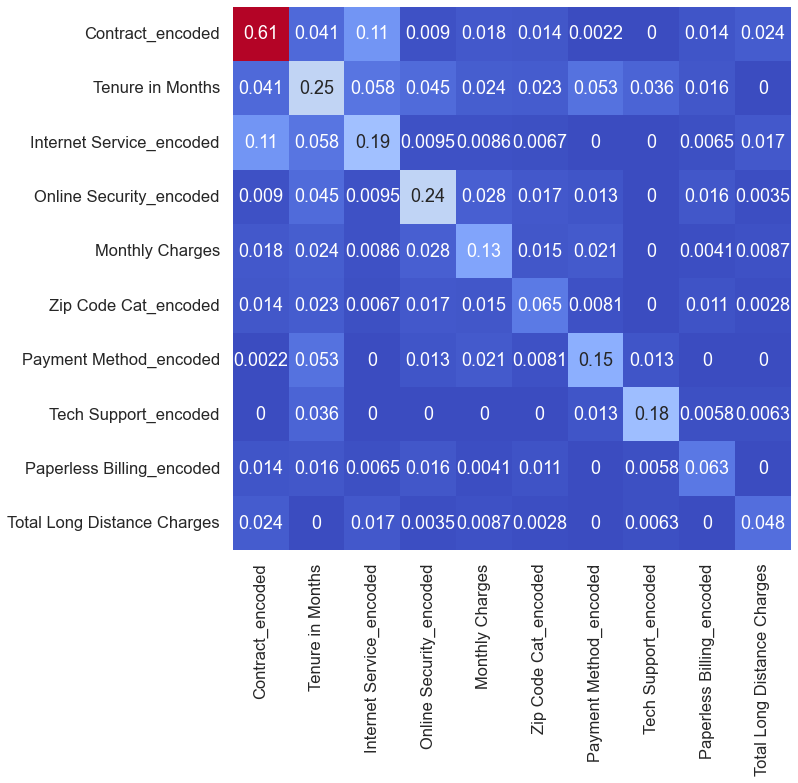

In [240]:
# shap interactions
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index = X_test.columns, columns = X_test.columns)

df.where(df.values == np.diagonal(df), df.values*2, inplace = True)

cols_of_interest = list(forest_importances.sort_values(ascending = False).head(10).index)

df_filtered = df[cols_of_interest].filter(items=cols_of_interest, axis=0)

# display
plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df_filtered, cmap='coolwarm', annot=True, fmt='.2g', cbar=False)
plt.yticks(rotation=0)
plt.show()

We see some resonably strong interaction effects involving contract, internet service, tenure in months and online security. Lets confirm the strongest interaction effects.

In [85]:
interactions = {}
processed = []
for col in df.columns:
    for v in df.index.values:
        if col != v and v not in processed:
            name = col + '.' + v
            interactions[name] = df[col][v]
            processed.append(col)
            
interactions_df = pd.DataFrame.from_dict(interactions, columns = ['interaction_value'], orient = 'index')
interactions_df.sort_values('interaction_value', ascending = False).head(5)

,interaction_value
Internet Service_encoded.Contract_encoded,0.105648
Tenure in Months.Internet Service_encoded,0.058394
Tenure in Months.Payment Method_encoded,0.053257
Tenure in Months.Online Security_encoded,0.044693
Tenure in Months.Contract_encoded,0.041484


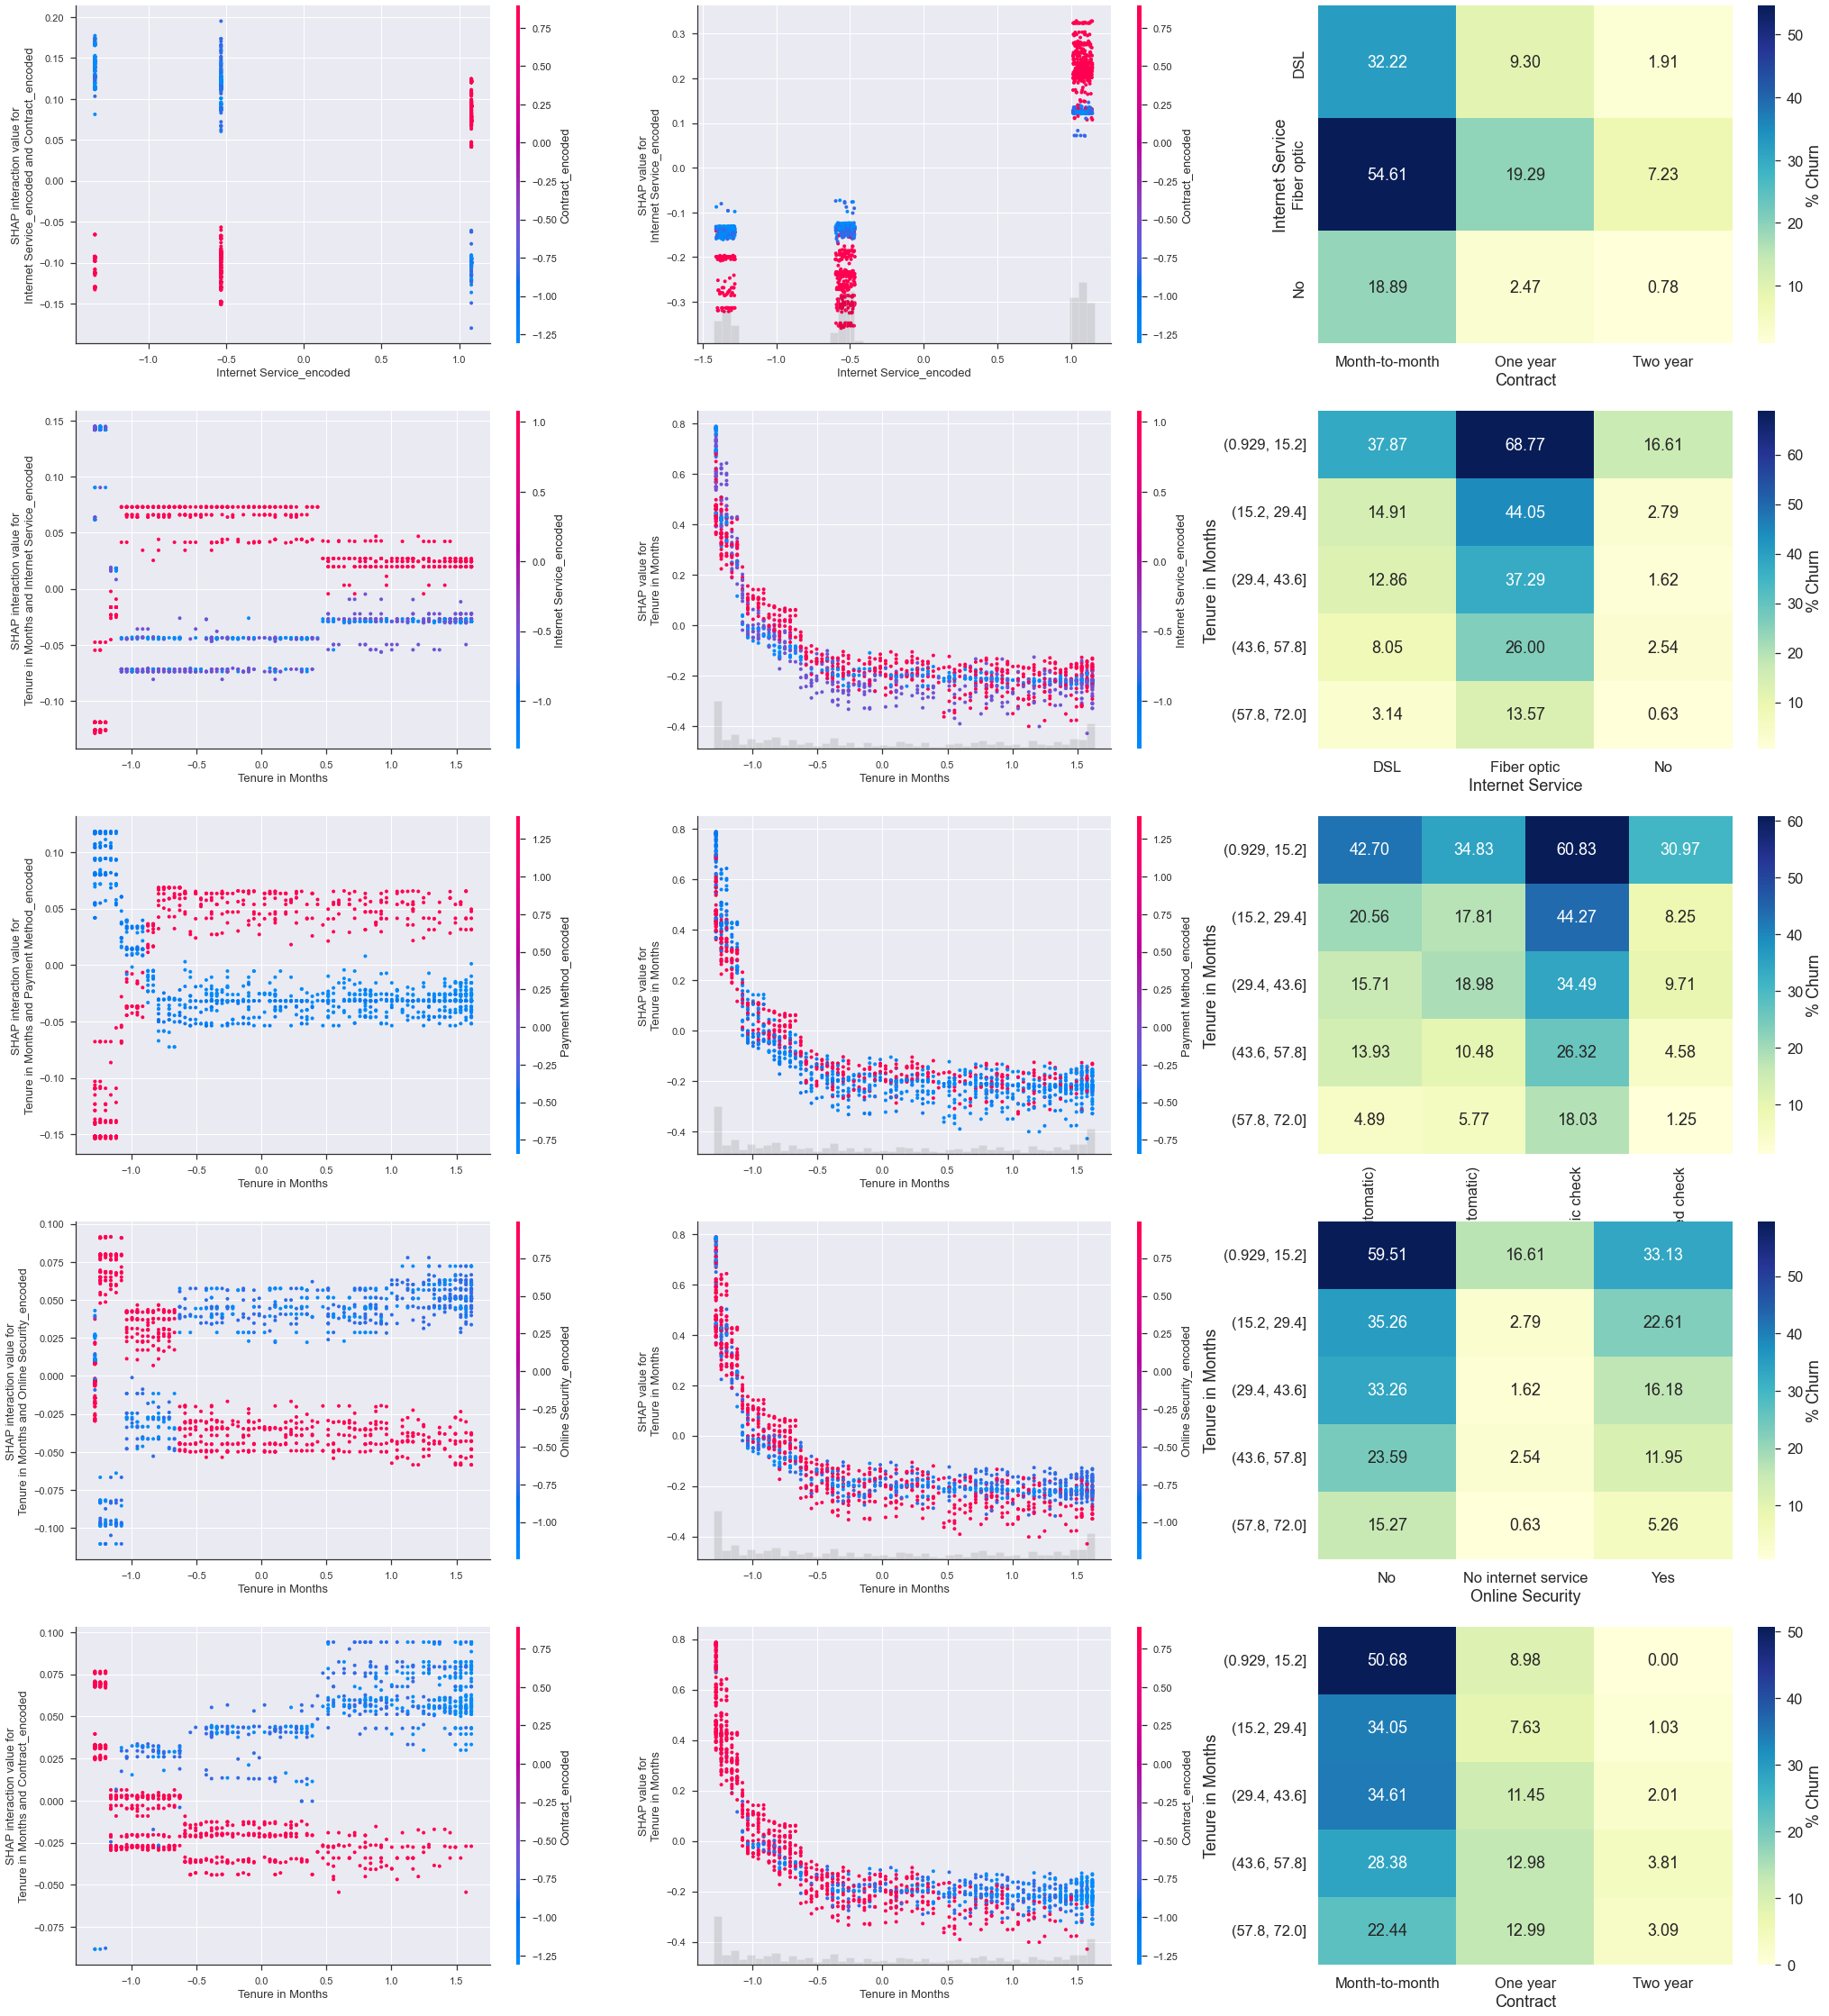

In [236]:
# visualise relationships for most sig interaction effects

# define viz functions
# two cat vars
def plot_two_cat_vars(var1, var2, target, data, ax):
    # Group the data by var1 and var2 and calculate the percentage of target=1
    grouped_data = data.groupby([var1, var2])[target].mean().unstack() * 100
    sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True, cbar_kws={'label': f'% {target}'}, ax = ax)

    
def plot_one_cat_one_num(categorical_var, numerical_var, target, data, ax):
    grouped_data = data.groupby([pd.cut(data[numerical_var], bins=5), categorical_var])[target].mean().unstack() * 100
    sns.heatmap(grouped_data, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True, cbar_kws={'label': f'% {target}'}, ax = ax)

list_1 = ['Internet Service_encoded', 'Tenure in Months', 'Tenure in Months', 'Tenure in Months', 'Tenure in Months']
list_2 = ['Contract_encoded', 'Internet Service_encoded', 'Payment Method_encoded', 'Online Security_encoded', 'Contract_encoded']


fig, [[ax1, ax2, ax3], 
      [ax4, ax5, ax6],
      [ax7, ax8, ax9],
      [ax10, ax11, ax12],
      [ax13, ax14, ax15]] = plt.subplots(nrows=5, ncols=3, figsize=(35,40))

ax_list_1 = [ax1, ax4, ax7, ax10, ax13]
ax_list_2 = [ax2, ax5, ax8, ax11, ax14]
ax_list_3 = [ax3, ax6, ax9, ax12, ax15]


for var1, var2, ax in zip(list_1, list_2, ax_list_1):

    # plot interaction plot
    
    shap.dependence_plot(
        (var1, var2),
        shap_interaction, X_test,
        display_features=X_test, ax = ax, show = False)
    
for var1, var2, ax in zip(list_1, list_2, ax_list_2):    

    shap.plots.scatter(shap_values[:,var1], 
                       color = shap_values[:,var2], ax = ax, show = False)
    

for var1, var2, ax in zip(list_1, list_2, ax_list_3):   

        # check dtypes
    
    if var1.endswith('_encoded') == True:
        var1 = var1.replace("_encoded", "")
        
    if var2.endswith('_encoded') == True:
        var2 = var2.replace("_encoded", "")
        
    
    if is_string_dtype(churn_df[var1]) == True and is_string_dtype(churn_df[var2]) == True:
        
        
        plot_two_cat_vars(var1, var2, 'Churn', churn_df, ax = ax)
    
        
    elif is_string_dtype(churn_df[var1]) == True and is_numeric_dtype(churn_df[var2]) == True:
    
        categorical_var = var1
        numerical_var = var2
        
        plot_one_cat_one_num(categorical_var, numerical_var, 'Churn', churn_df, ax = ax)
            
    elif is_numeric_dtype(churn_df[var1]) == True and is_string_dtype(churn_df[var2]) == True:
    
        categorical_var = var2
        numerical_var = var1
         
        plot_one_cat_one_num(categorical_var, numerical_var, 'Churn', churn_df, ax = ax)
            
            
    
#plt.tight_layout()
plt.show()
        

According to the above plots:
- Internet service has the biggest impact on predictions when contract = 'month to month';
- Tenure in months seems to have a slightly bigger impact on predicting churn = 1 during the early months when internet service = DSL or no internet service. As tenure increases the SHAP value for tenure decreases below 0 (negative correlation with churn = 1). The correlation is more significant for internet service = DSL or no internet service;
- Payment methods not correlated with churn are positively correlated with churn when tenure in months is very low but negatively correlated with churn as tenure increases;
- When online security = no low tenure in months has a stronger impact on predicting churn = 1 compared to online security = yes. Online security = no has the opposite effect as tenure in months increases;
- Contract = month to month has a stronger impact on predicting churn = 1 during the early months. As tenure in months increases we see contract = month to month has the effect. We also notice that % churn increases for one year and two year as tenure in months increases.

# Conclusion: What is Causing Churn?

The above analysis suggests that multiple variables are linked to churn. These include:
- Contract: Customers that are not locked into a one or two year contract are much more likely to churn than customers that are on a contract;
- Tenure: Customers that have been with the company for only a short time are much more likely to churn;
- Internet Service: Customers that are on a fibre optic plan are much more likely to churn than customers with no internet service or DSL;
- Online Security and Tech Support: Customers with these services in their contract are less likely to churn than customers that opted out of them;
- Payment method: Customers that pay by electronic check are much more likely to churn than customers that pay with other methods;
- Monthly charges: Customers with higher monthly charges are more likely to churn;
- Location variables: Location has strong impact on predicting churn when the location is around San Diego city.

# Strategies to Address Churn

- Customers that are on a month to month contract are much more likely to churn than customers on contracts so incentivising customers to go on a contract (say by throwing in free online security or tech support) could be a good strategy to reduce churn;
- We see customers on fibre optic plans are much more likely to churn, especially those that are also on month to month contracts and without extra services like online security and tech support. This suggests there may be some issue with this service that is causing customers to churn. Perhaps offering free tech support and/or online security while any potential issues are investigated could be a good way to reduce customers switching to another provider. Another option could be to offer the service at a discounted rate as high monthly charges also seem to be a factor that is correlated with churn;
- We see that customers located around San Diego city are much more likely to churn than other customers. Various factors could be at play here including issues with the provision of service in this area or maybe there is a new competitior in this market that is stealing customers. If it is the latter perhaps the company could offer a more competitive service in this area. The company could also step up marketing efforts in this area. 